# Simulating optical auto correlation of a pulsed laser (with chirp)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants
from scipy import integrate
from scipy import fftpack
from scipy import signal
from scipy import interpolate

import ipywidgets as widgets
from IPython.core.debugger import set_trace
from datetime import datetime

Electric field of the laser $E_{0,gauss}(t)$ is relative to the form:

$$ E_{0,gauss}(t) \sim \frac{A}{\sqrt{2 \cdot \pi \cdot \tau_0^2}} \exp\left(-\frac{t^2}{2 \cdot \tau_0^2}\right)\exp(-i \omega t)$$

with the orginal pulse area $A$, the pulse duration $\tau_0$ and the central frequency $w$.

Applying a Gaussian chirp filter with the chirp coefficient $\alpha$ transforms $E_0(t)$ into

$$E_{gauss}(t) \sim f_{gauss}(t) \cdot \exp\left(-i \omega t - i \frac{at^2}{2}\right)$$

with
$$f_{gauss}(t) = \frac{A}{\sqrt{2 \cdot \pi \cdot \tau_0 \cdot \tau}} \exp\left(-\frac{t^2}{2 \cdot \tau^2}\right)$$

where $\tau = \sqrt{\alpha^2 / \tau_0^2 + \tau_0^2}$ characterizes the chirped pulse length and $a = \alpha/(\alpha^2+\tau_0^4)$ is the frequency chirp rate.

see: 
- Glässl, M., Barth, A. M., Gawarecki, K., MacHnikowski, P., Croitoru, M. D., Lüker, S., … Axt, V. M. (2013). Biexciton state preparation in a quantum dot via adiabatic rapid passage: Comparison between two control protocols and impact of phonon-induced dephasing. Physical Review B - Condensed Matter and Materials Physics, 87(8), 1–8. http://doi.org/10.1103/PhysRevB.87.085303
- Hirayama, T., & Sheik-Bahae, M. (2002). Real-time chirp diagnostic for ultrashort laser pulses. Optics Letters, 27(10), 860. http://doi.org/10.1364/OL.27.000860).

In [2]:
def gen_tau(alpha, tau_0):
    return np.sqrt(alpha**2 / tau_0**2 + tau_0**2)

def gen_a(alpha, tau_0):
    return alpha / (alpha**2 + tau_0**4)

def f_gauss(t, A, tau_0, omega, alpha):
    return A / np.sqrt(2 * np.pi * tau_0 * gen_tau(alpha, tau_0)
                      ) * np.exp(- t**2 / (2 * gen_tau(alpha, tau_0)**2))

def E_gauss(t, A, tau_0, omega, alpha):
     return f_gauss(t, A, tau_0, omega, alpha) * np.exp(-1j * omega * t - 1j * gen_a(alpha, tau_0) * t**2 / 2)



MaiTai Laser | values
-----------|--------------
repitition rate| 80 MHz
center wavelength (tunable) $\lambda_0$| 700 nm to 1000 nm
power | 3.2 Watt
pulse duration $\tau_0$ | 100 fs - 20 ps

We start with the pulse duration $\tau_0$ in (ps) and choose for the central wavelength $\lambda$ = 785e3 (pm).

We also define the original pulse area $A$.

In [3]:
tau_0_laser = 0.1
lambda_laser = 785e3

frequency_laser = constants.c / lambda_laser
omega_laser = 2 * np.pi * frequency_laser

We calculate E for different $\alpha$ in (ps)$^2$.

In [4]:
alpha_values = np.array((0, 1e-2, 2e-2))

Calculate $A_{laser}$-array so that $\int f(t) dt = 1$

In [5]:
A_laser = np.empty(alpha_values.size)    
for i in range(alpha_values.size):
    A_laser[i] = 1 / integrate.quad(
        f_gauss, - np.inf, np.inf, args=(1, tau_0_laser, omega_laser, alpha_values[i]))[0]

Set t_limit to 0.8 (ps)

In [6]:
t_limit = 3 * tau_0_laser

In [9]:
t_values_1 = np.linspace(-t_limit, t_limit * 3, 3000)

E_gauss_values_1 = np.empty((t_values_1.size, alpha_values.size), dtype=complex)
for i in range(alpha_values.size):
    E_gauss_values_1[:,i] = E_gauss(t_values_1, A_laser[i], tau_0_laser,
                                    omega_laser, alpha_values[i])

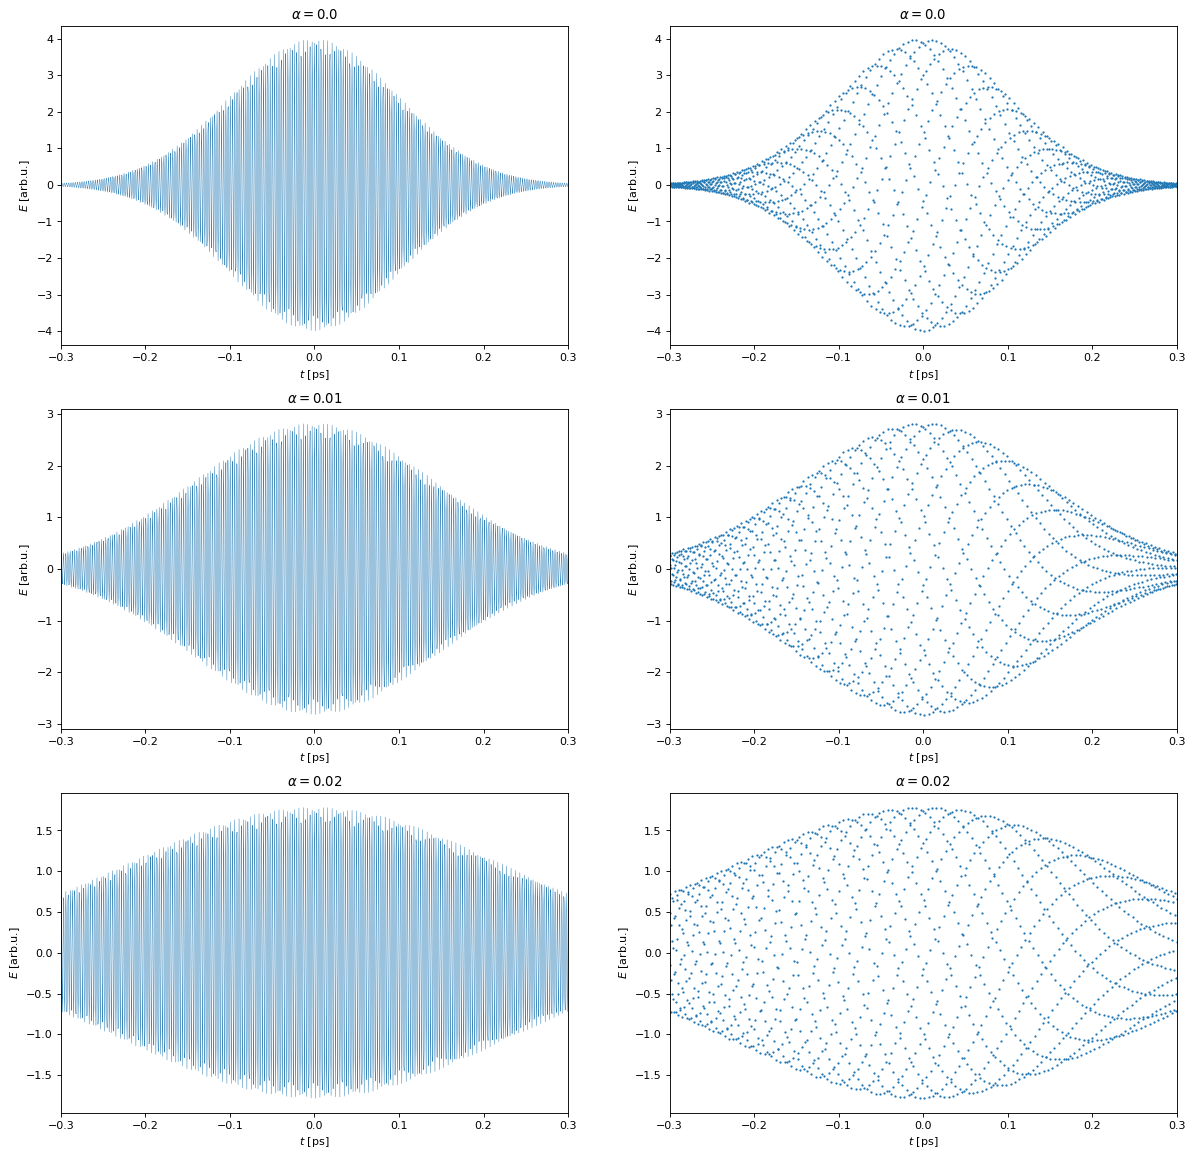

In [10]:
# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(18, 18), dpi=80)
for i in range(alpha_values.size):
    plt.subplot(alpha_values.size, 2, 2 * i + 1)
    plt.title(r"$\alpha = {}$".format(alpha_values[i]))
    plt.xlabel(r"$t$ [ps]")
    plt.ylabel(r"$E$ [arb.u.]")
    plt.xlim(-t_limit, t_limit)
    plt.plot(t_values_1, np.real(E_gauss_values_1[:,i]), linewidth=0.4)
    
    plt.subplot(alpha_values.size, 2, 2 * i + 2)
    plt.title(r"$\alpha = {}$".format(alpha_values[i]))
    plt.xlabel(r"$t$ [ps]")
    plt.ylabel(r"$E$ [arb.u.]")
    plt.xlim(-t_limit , t_limit)
    plt.plot(t_values_1, np.real(E_gauss_values_1[:,i]), ".", markersize=2)

plt.show()

# Interferometric autocorrelation

![Setup for an interferometric autocorrelator](https://upload.wikimedia.org/wikipedia/en/d/dd/Optical-interferometric-autocorrelation-setup.png)

Setup for an interferometric autocorrelator, similar to the field autocorrelator above, with the following optics added:
- **L**: converging lens,
- **SHG**: second-harmonic generation crystal,
- **F**: spectral filter to block the fundamental wavelength.

(see https://en.wikipedia.org/wiki/Optical_autocorrelation)

The intensity recorded by the detecter is:

$$ I_M(\tau) = \int_{-\infty}^{+\infty}|(E(t)+E(t-\tau))^2|^2dt $$

In [11]:
def I_M_gauss(tau_values, A, tau_0, omega, alpha):
    I_M_values = np.array(())
    for tau in tau_values:
        func = lambda t: np.abs((E_gauss(t, A, tau_0, omega, alpha)
                                 + E_gauss(t - tau, A, tau_0, omega, alpha))**2)**2
        # "[0]" because quad returns array, with "[0]" as the result and "[1]" as the error
        I_M_values = np.append(I_M_values,
                               integrate.quad(func, - np.inf, np.inf)[0])        
    return I_M_values

Number of $\tau$-values to calculate:

In [12]:
tau_limit = tau_0_laser * 4

Calculate the number of values so we can fft to at least $3 \cdot \omega$ 

$$3 \cdot \frac{\omega_{laser}}{2\pi} < f_{nyq} = \frac{f_{sampling}}{2} = \frac{\frac{\textit{number_tau_values}}{\textit{tau_limit} \cdot 2}}{2} $$

$$\Rightarrow \textit{number_tau_values} = \frac{6}{\pi} \cdot \textit{tau_limit} \cdot \omega_{laser} $$

"//100 * 100 + 100" so we don't get an integer multiple (which brings weird results)

In [13]:
number_tau_values = int((6 / np.pi * tau_limit * omega_laser)//100 * 100 + 100)

In [14]:
def gen_I_M_gauss_values(tau_limit, number_tau_values, alpha_values,  A, tau_0, omega):
    tau_values = np.linspace(-tau_limit, tau_limit, number_tau_values)
    I_M_gauss_values = np.empty((tau_values.size, alpha_values.size))    
    for i in range(alpha_values.size):
        I_M_gauss_values[:,i] = I_M_gauss(tau_values, A, tau_0, omega, alpha_values[i])
    return tau_values, I_M_gauss_values

In [16]:
while(True):
    answer = input('Should data be loaded from file (l) or generated (g)?: ')
    if answer == "l":
        path = r"../../Data/Autocorrelator/Simulation/" + \
        r"Autocorrelation_Simulation_Gauss_2018-09-28 16_04_09.315948.txt"
        
        data = np.loadtxt(path)
        tau_values_1 = data[:, 0]
        I_M_gauss_values_1 = data[:, 1:]
        break
    if answer == "g":
        tau_values_1, I_M_gauss_values_1 = gen_I_M_gauss_values(tau_limit, number_tau_values,
                                                              alpha_values,  A_laser,
                                                              tau_0_laser, omega_laser)
        
        path = r"../../Data/Autocorrelator/Simulation/"
        np.savetxt(path + "Autocorrelation_Simulation_Gauss_"
                   + str(datetime.now()).replace(":", "_") 
                   + ".txt", np.append(tau_values_1[:, np.newaxis], I_M_gauss_values_1, axis=1),
                   header = "tau_values | I(alpha = " + str(alpha_values) + ")")
        break

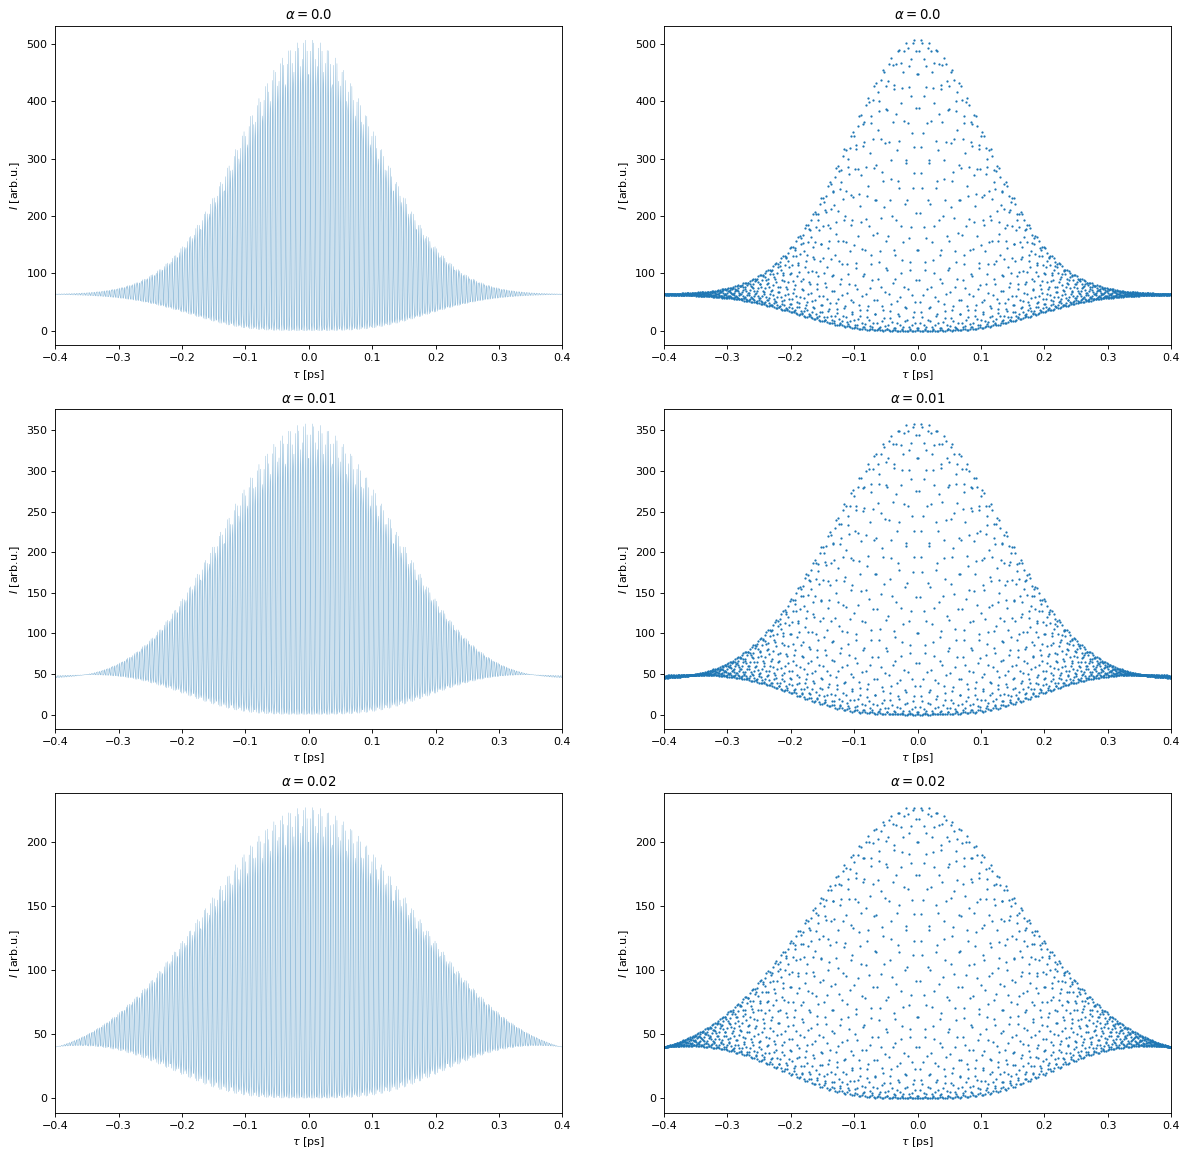

In [17]:
# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(18, 18), dpi=80)

for i in range(alpha_values.size):
    plt.subplot(alpha_values.size, 2, 2 * i + 1)
    plt.title(r"$\alpha = {}$".format(alpha_values[i]))
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$I$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_gauss_values_1[:,i], linewidth=0.2)
   
    
    plt.subplot(alpha_values.size, 2, 2 * i + 2)
    plt.title(r"$\alpha = {}$".format(alpha_values[i]))
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$I$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_gauss_values_1[:,i], ".", markersize=2)    

plt.show()

## FFT
Transform interpolated signal into frequency-space per FFT.

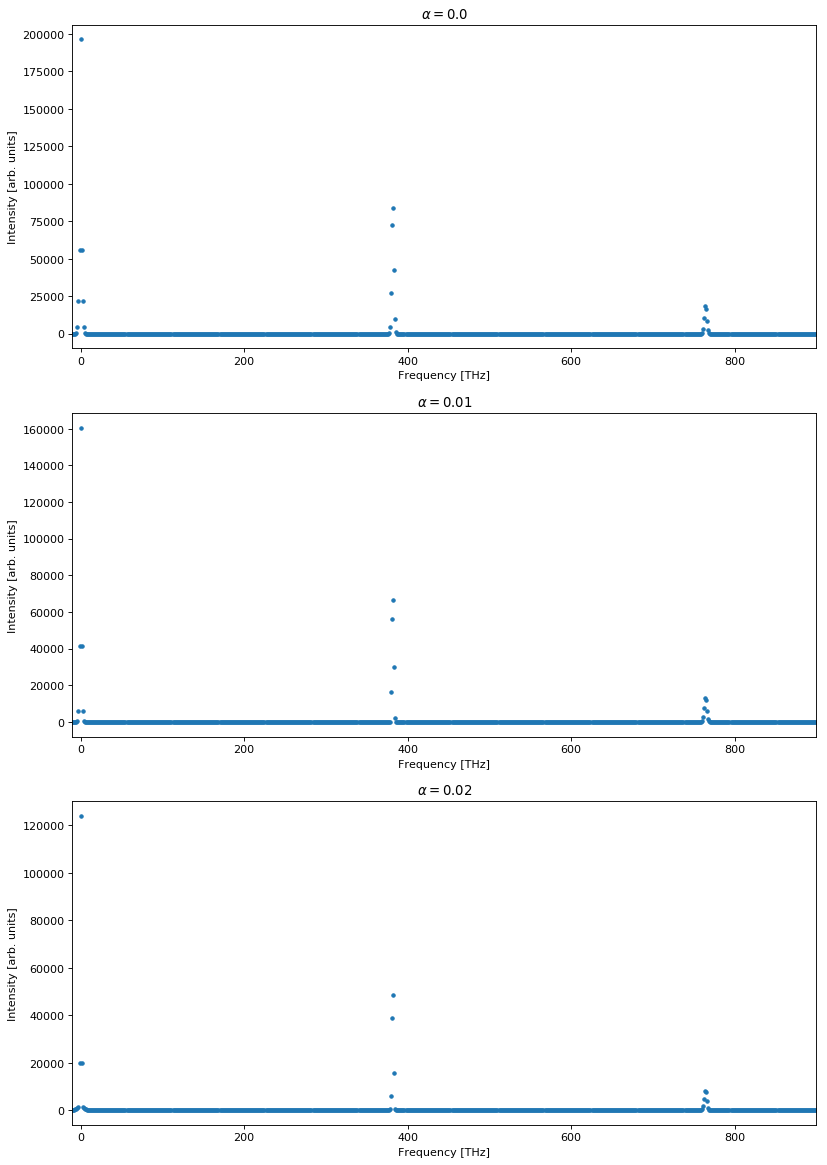

In [18]:
# Plot the FFT power
plt.figure(figsize=(12, 10), dpi=80)
plt.subplots_adjust(top = 1.5)

sample_freq_gauss = np.empty(tau_values_1.size)
I_M_gauss_fft = np.empty((tau_values_1.size, alpha_values.size), dtype=complex)

for i in range(alpha_values.size):
    # The FFT of the signal
    I_M_gauss_fft[:, i] = fftpack.fft(I_M_gauss_values_1[:,i])
    # And the power (sig_fft is of complex dtype)
    data_power = np.abs(I_M_gauss_fft[:, i])
    # The corresponding frequencies
    sample_freq_gauss = fftpack.fftfreq(I_M_gauss_values_1[:,i].size,
                                        d = tau_limit * 2 / tau_values_1.size)
    
    plt.subplot(alpha_values.size, 1, i + 1)
    plt.title(r"$\alpha = {}$".format(alpha_values[i]))
    plt.xlabel('Frequency [THz]')
    plt.ylabel('Intensity [arb. units]')
    plt.xlim(-10, 900)    
    plt.plot(sample_freq_gauss, data_power, ".")

plt.show()

## Implement Filter
Citation from MOSAIC paper:
"The bandpass filter functions were taken as rectangular functions centered at $\omega$
and $2\omega$ having bandwidths of $\omega$.

Alternative with "correct" filter implementations:

Scipy Signal Filter Tutorial (https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html)

How many taps? (https://dsp.stackexchange.com/a/31210)

In [19]:
I_M_gauss_filtered_fft = I_M_gauss_fft.copy()

for j in range(alpha_values.size):
    for i in range(data_power.size):
        if frequency_laser * 0.5 < abs(sample_freq_gauss[i]) < frequency_laser * 1.5:
            I_M_gauss_filtered_fft[i, j] = 0
        if frequency_laser * 1.5 < abs(sample_freq_gauss[i]) < frequency_laser * 2.5:
            I_M_gauss_filtered_fft[i, j] = I_M_gauss_filtered_fft[i, j] * 2

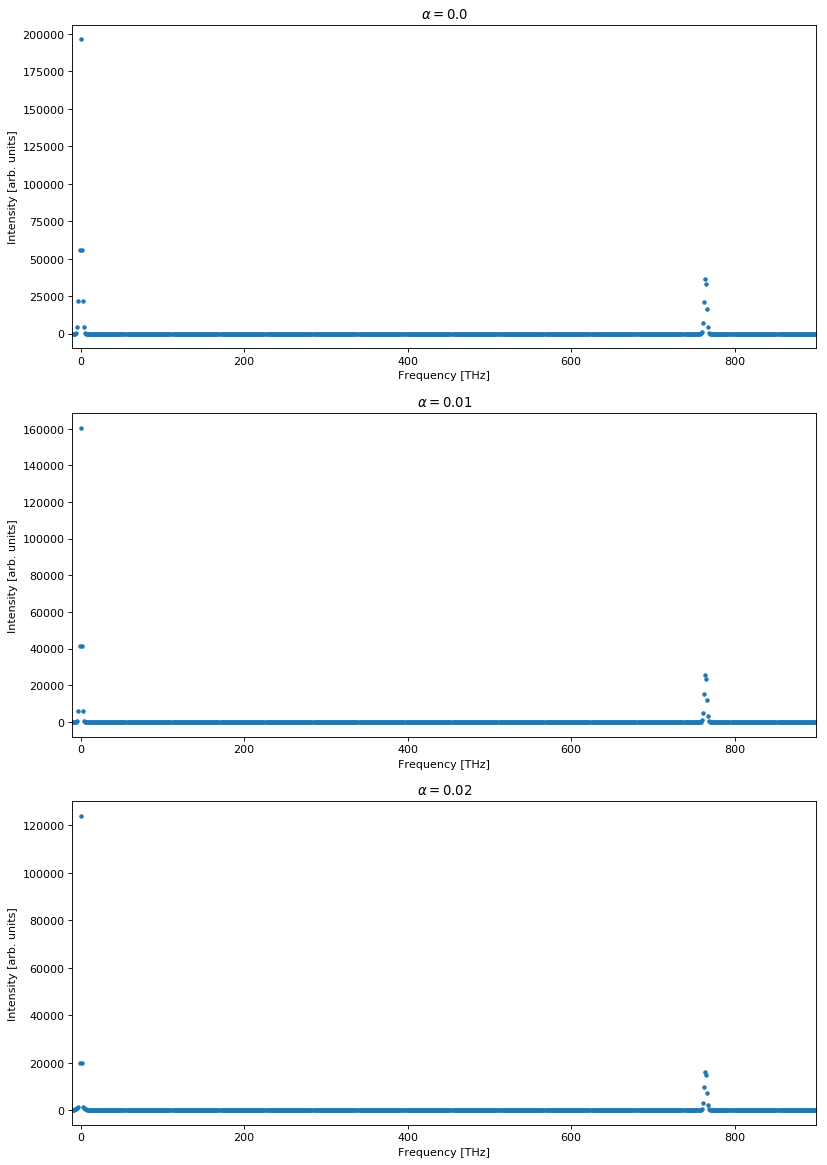

In [20]:
# Plot the FFT power
plt.figure(figsize=(12, 10), dpi=80)
plt.subplots_adjust(top = 1.5)

for i in range(alpha_values.size):
    data_power = np.abs(I_M_gauss_filtered_fft[:, i])
    
    plt.subplot(alpha_values.size, 1, i + 1)
    plt.title(r"$\alpha = {}$".format(alpha_values[i]))
    plt.xlabel('Frequency [THz]')
    plt.ylabel('Intensity [arb. units]')
    plt.xlim(-10, 900)
    plt.plot(sample_freq_gauss, data_power, ".")

plt.show()

## Inverse FFT
Transform filtered signal back into time-space per inverse FFT.

In [21]:
I_M_gauss_filtered_values = np.empty((tau_values_1.size, alpha_values.size))
for i in range(alpha_values.size):
    I_M_gauss_filtered_values[:,i] = np.real(
        fftpack.ifft(I_M_gauss_filtered_fft[:, i]))

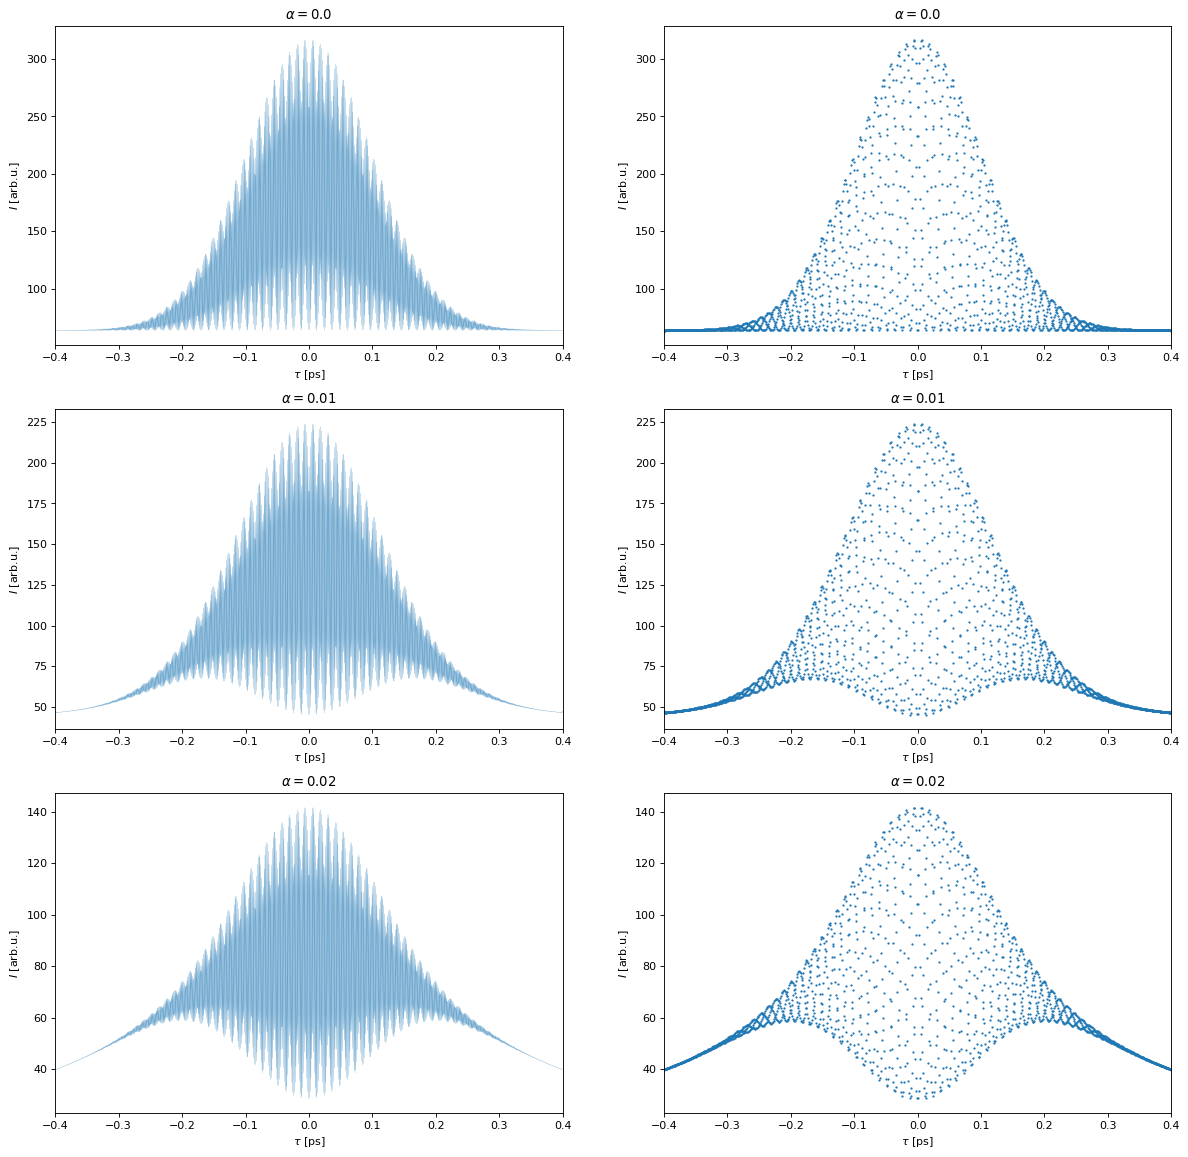

In [22]:
# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(18, 18), dpi=80)

for i in range(alpha_values.size):
    plt.subplot(alpha_values.size, 2, 2 * i + 1)
    plt.title(r"$\alpha = {}$".format(alpha_values[i]))
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$I$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_gauss_filtered_values[:,i], linewidth=0.2)
   
    
    plt.subplot(alpha_values.size, 2, 2 * i + 2)
    plt.title(r"$\alpha = {}$".format(alpha_values[i]))
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$I$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_gauss_filtered_values[:,i], ".", markersize=2)    

plt.show()

## Calculate Envelope

The envelopes are determined using spline interpolation over local minima separated by minima_number_samples.

In [23]:
minima_number_samples = 3

In [24]:
# Cut out the first and last 300 values because they are not defined for the interpolation
tau_values_2 = tau_values_1[300:-300]

I_M_gauss_envelope_fit_values = np.empty((tau_values_2.size, alpha_values.size))
for i in range(alpha_values.size):
    # order=3 means that it checks the local minimum for three neighbors each side
    mask_local_min = signal.argrelmin(I_M_gauss_filtered_values[:,i], order=minima_number_samples)
    tau_new = tau_values_1[mask_local_min]
    I_M_gauss_envelope = I_M_gauss_filtered_values[:,i][mask_local_min]
    envelope_function = interpolate.interp1d(tau_new, I_M_gauss_envelope, kind="cubic")
    I_M_gauss_envelope_fit_values[:,i] = envelope_function(tau_values_2)

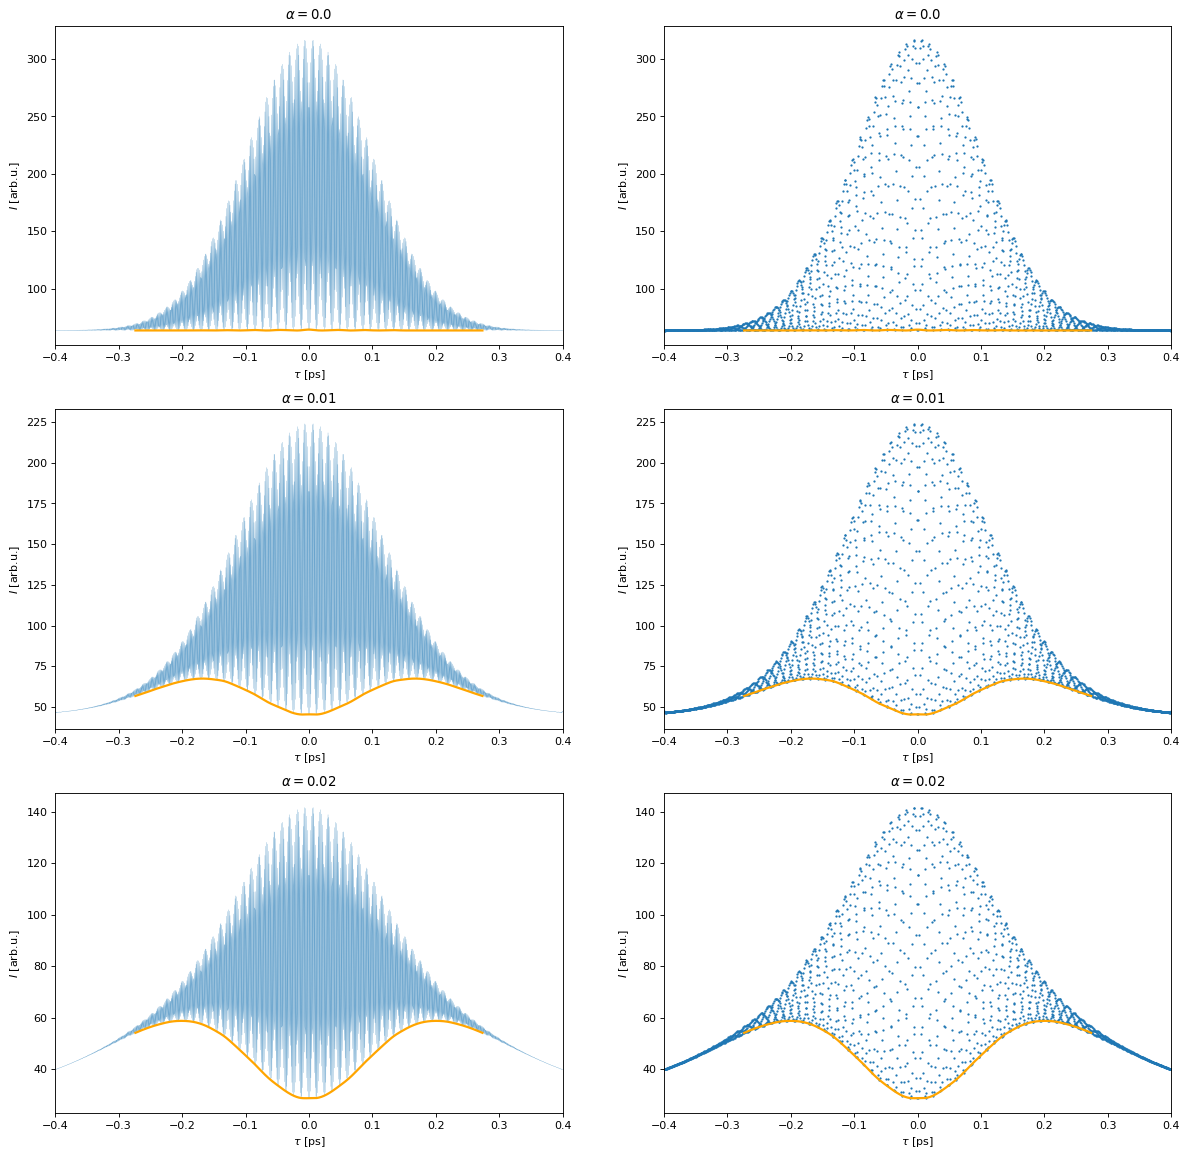

In [25]:
# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(18, 18), dpi=80)

for i in range(alpha_values.size):
    plt.subplot(alpha_values.size, 2, 2 * i + 1)
    plt.title(r"$\alpha = {}$".format(alpha_values[i]))
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$I$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_gauss_filtered_values[:,i], linewidth=0.2)
    plt.plot(tau_values_2, I_M_gauss_envelope_fit_values[:,i], linewidth=2, color="orange")
   
    
    plt.subplot(alpha_values.size, 2, 2 * i + 2)
    plt.title(r"$\alpha = {}$".format(alpha_values[i]))
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$I$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_gauss_filtered_values[:,i], ".", markersize=2)
    plt.plot(tau_values_2, I_M_gauss_envelope_fit_values[:,i], linewidth=2, color="orange")

plt.show()

## Fit Envelope
(see Hirayama, T., & Sheik-Bahae, M. (2002). Real-time chirp diagnostic for ultrashort laser pulses. Optics Letters, 27(10), 860. http://doi.org/10.1364/OL.27.000860)

The lower bound (minima envelope) of the MOSAIC trace is therefore given by

$$S^{min}_{MOSAIC}(\tau)=g(\tau)-[g_s^2(\tau)+g_c^2(\tau)]^{1/2}$$

with 

$$g(\tau)=\int f(t)f(t+\tau)dt$$
$$g_s(\tau)=\int f(t)f(t+\tau)sin(2\Delta\phi)dt$$
$$g_c(\tau)=\int f(t)f(t+\tau)cos(2\Delta\phi)dt$$

and

$$E(t) \sim f(t)$$
$$\Delta \phi(t, \tau) = \phi(t + \tau) - \phi(t)$$
$$\phi_{gauss}(t) = \frac{at^2}{2}$$
$$\int f(t) dt = 1$$